In [ ]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

from baselines import evaluate_cnn_across_epsilons, train_phase1_model, train_phase2_model, create_inference_model

In [2]:
data = loadmat('../data/processed/improved_signals.mat')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
signal2_start_times = data['signal2_start_times'].squeeze()
print(f"Improved Test Set Shape: {X_test.shape}")

Improved Test Set Shape: (5628, 8, 500, 2)


## Define Epsilon Values

In [3]:
epsilon_values_inf = np.linspace(0.0, 0.005, 20)
epsilon_values_l2 = np.linspace(0.0, 0.05, 20)

In [4]:
epsilon_linf = epsilon_values_inf[4]
print(f"Selected epsilon values: Linf = {epsilon_linf}")

Selected epsilon values: Linf = 0.0010526315789473684


In [5]:
epsilon_l2 = epsilon_values_l2[4]
print(f"Selected epsilon values: L2 = {epsilon_l2}")

Selected epsilon values: L2 = 0.010526315789473684


## Defense Distillation

In [6]:
T = 10.0

# Phase 1 — Train model with softmax(T) on hard labels
phase1_model = train_phase1_model(X_train, y_train, T=T, save_path="../models/attack/teacher_phase1.keras")

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.5196 - loss: 0.6774 - val_accuracy: 0.9242 - val_loss: 0.4939 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9337 - loss: 0.3950 - val_accuracy: 0.9383 - val_loss: 0.2199 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.9513 - loss: 0.1931 - val_accuracy: 0.9554 - val_loss: 0.1518 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.9577 - loss: 0.1428 - val_accuracy: 0.9592 - val_loss: 0.1258 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.9607 - loss: 0.1241 - val_accuracy: 0.9617 - val_loss: 0.1130 - learning_rate: 1.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9640 - loss: 0.1102 - val_accuracy: 0.9654 - val_loss: 0.1065 - learning_rate: 1.0000e-04
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/ste

In [7]:
# Generate soft labels
soft_labels = phase1_model.predict(X_train)

750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


In [8]:
# Phase 2 — Retrain with softmax(T) on soft labels
phase2_model = train_phase2_model(X_train, soft_labels, T=T, save_path="../models/attack/student_phase2.keras")

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5149 - loss: 0.5911 - val_accuracy: 0.8896 - val_loss: 0.4222 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9190 - loss: 0.3202 - val_accuracy: 0.9479 - val_loss: 0.1366 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9592 - loss: 0.1077 - val_accuracy: 0.9725 - val_loss: 0.0627 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9738 - loss: 0.0531 - val_accuracy: 0.9775 - val_loss: 0.0365 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9787 - loss: 0.0321 - val_accuracy: 0.9858 - val_loss: 0.0232 - learning_rate: 1.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9838 - loss: 0.0204 - val_accuracy: 0.9837 - val_loss: 0.0174 - learning_rate: 1.0000e-04
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - acc

In [9]:
# Inference model with softmax(T=1)
model_distill = create_inference_model("../models/attack/student_phase2.keras")

In [10]:
# Evaluate on clean test set
test_loss, test_acc = model_distill.evaluate(X_test, y_test)
print(f"Clean test accuracy (defensive distillation): {test_acc:.4f}")

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9791 - loss: 0.1349
Clean test accuracy (defensive distillation): 0.9778


## Evaluate and Compare Results

In [11]:
fgsm_inf = pd.read_csv('../results/improved_attacks/fgsm_inf_accuracy.csv')
pgd_inf = pd.read_csv('../results/improved_attacks/pgd_inf_accuracy.csv')
fgsm_l2 = pd.read_csv('../results/improved_attacks/fgsm_l2_accuracy.csv')
pgd_l2 = pd.read_csv('../results/improved_attacks/pgd_l2_accuracy.csv')

In [12]:
# distillation
acc_distill_fgsm_inf, preds_distill_fgsm_inf = evaluate_cnn_across_epsilons(
    model_distill, X_test, y_test,
    epsilon_values_inf, attack_type='fgsm', norm='inf'
)

[FGSM-inf] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[FGSM-inf] Epsilon = 0.00026
Mean absolute perturbation at epsilon=0.00026: 0.000161
[FGSM-inf] Epsilon = 0.00053
Mean absolute perturbation at epsilon=0.00053: 0.000321
[FGSM-inf] Epsilon = 0.00079
Mean absolute perturbation at epsilon=0.00079: 0.000482
[FGSM-inf] Epsilon = 0.00105
Mean absolute perturbation at epsilon=0.00105: 0.000643
[FGSM-inf] Epsilon = 0.00132
Mean absolute perturbation at epsilon=0.00132: 0.000804
[FGSM-inf] Epsilon = 0.00158
Mean absolute perturbation at epsilon=0.00158: 0.000964
[FGSM-inf] Epsilon = 0.00184
Mean absolute perturbation at epsilon=0.00184: 0.001125
[FGSM-inf] Epsilon = 0.00211
Mean absolute perturbation at epsilon=0.00211: 0.001286
[FGSM-inf] Epsilon = 0.00237
Mean absolute perturbation at epsilon=0.00237: 0.001447
[FGSM-inf] Epsilon = 0.00263
Mean absolute perturbation at epsilon=0.00263: 0.001607
[FGSM-inf] Epsilon = 0.00289
Mean absolute perturbation at epsilo

In [13]:
fgsm_inf['distill_trained'] = acc_distill_fgsm_inf

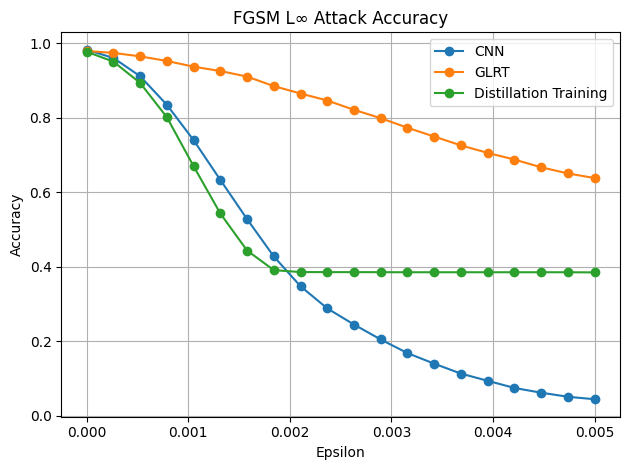

In [14]:
fgsm_inf.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "distill_trained"],
    marker='o'
)

plt.title("FGSM L∞ Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "Distillation Training"])
plt.tight_layout()
plt.show()

In [26]:
fgsm_inf.to_csv('../results/baseline/fgsm_inf_accuracy_with_distill.csv', index=False)

In [15]:
# distillation
acc_distill_fgsm_l2, preds_distill_fgsm_l2 = evaluate_cnn_across_epsilons(
    model_distill, X_test, y_test,
    epsilon_values_l2, attack_type='fgsm', norm='2'
)

[FGSM-2] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[FGSM-2] Epsilon = 0.00263
Mean absolute perturbation at epsilon=0.00263: 0.000001
[FGSM-2] Epsilon = 0.00526
Mean absolute perturbation at epsilon=0.00526: 0.000002
[FGSM-2] Epsilon = 0.00789
Mean absolute perturbation at epsilon=0.00789: 0.000004
[FGSM-2] Epsilon = 0.01053
Mean absolute perturbation at epsilon=0.01053: 0.000005
[FGSM-2] Epsilon = 0.01316
Mean absolute perturbation at epsilon=0.01316: 0.000006
[FGSM-2] Epsilon = 0.01579
Mean absolute perturbation at epsilon=0.01579: 0.000007
[FGSM-2] Epsilon = 0.01842
Mean absolute perturbation at epsilon=0.01842: 0.000008
[FGSM-2] Epsilon = 0.02105
Mean absolute perturbation at epsilon=0.02105: 0.000010
[FGSM-2] Epsilon = 0.02368
Mean absolute perturbation at epsilon=0.02368: 0.000011
[FGSM-2] Epsilon = 0.02632
Mean absolute perturbation at epsilon=0.02632: 0.000012
[FGSM-2] Epsilon = 0.02895
Mean absolute perturbation at epsilon=0.02895: 0.000013
[FGS

In [16]:
fgsm_l2['distill_trained'] = acc_distill_fgsm_l2

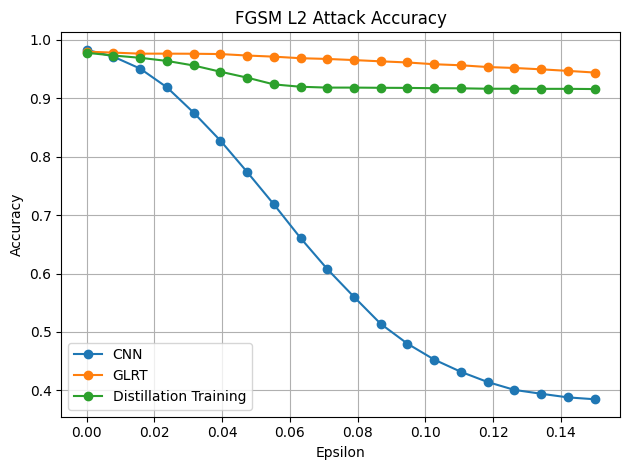

In [17]:
fgsm_l2.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "distill_trained"],
    marker='o'
)

plt.title("FGSM L2 Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "Distillation Training"])
plt.tight_layout()
plt.show()

In [27]:
fgsm_l2.to_csv('../results/baseline/fgsm_l2_accuracy_with_distill.csv', index=False)

In [18]:
# distillation
acc_distill_pgd_inf, preds_distill_pgd_inf = evaluate_cnn_across_epsilons(
    model_distill, X_test, y_test,
    epsilon_values_inf, attack_type='pgd', norm='inf'
)

[PGD-inf] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[PGD-inf] Epsilon = 0.00026
Mean absolute perturbation at epsilon=0.00026: 0.000158
[PGD-inf] Epsilon = 0.00053
Mean absolute perturbation at epsilon=0.00053: 0.000313
[PGD-inf] Epsilon = 0.00079
Mean absolute perturbation at epsilon=0.00079: 0.000464
[PGD-inf] Epsilon = 0.00105
Mean absolute perturbation at epsilon=0.00105: 0.000613
[PGD-inf] Epsilon = 0.00132
Mean absolute perturbation at epsilon=0.00132: 0.000760
[PGD-inf] Epsilon = 0.00158
Mean absolute perturbation at epsilon=0.00158: 0.000905
[PGD-inf] Epsilon = 0.00184
Mean absolute perturbation at epsilon=0.00184: 0.001046
[PGD-inf] Epsilon = 0.00211
Mean absolute perturbation at epsilon=0.00211: 0.001182
[PGD-inf] Epsilon = 0.00237
Mean absolute perturbation at epsilon=0.00237: 0.001308
[PGD-inf] Epsilon = 0.00263
Mean absolute perturbation at epsilon=0.00263: 0.001416
[PGD-inf] Epsilon = 0.00289
Mean absolute perturbation at epsilon=0.00289: 0

In [19]:
pgd_inf['distill_trained'] = acc_distill_pgd_inf

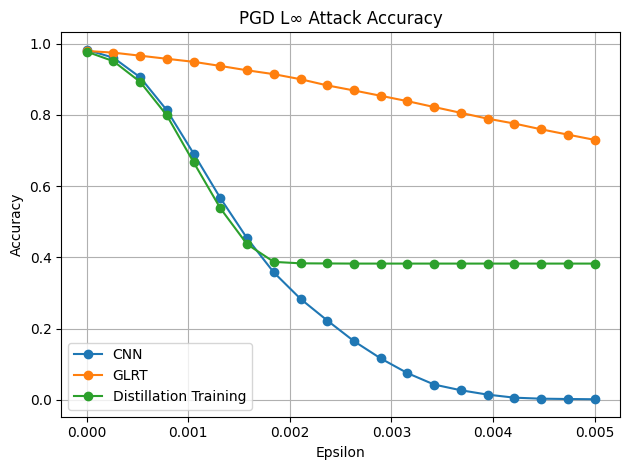

In [20]:
pgd_inf.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "distill_trained"],
    marker='o'
)

plt.title("PGD L∞ Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "Distillation Training"])
plt.tight_layout()
plt.show()

In [28]:
pgd_inf.to_csv('../results/baseline/pgd_inf_accuracy_with_distill.csv', index=False)

In [21]:
# distillation
acc_distill_pgd_l2, preds_distill_pgd_l2 = evaluate_cnn_across_epsilons(
    model_distill, X_test, y_test,
    epsilon_values_l2, attack_type='pgd', norm='2'
)

[PGD-2] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[PGD-2] Epsilon = 0.00263
Mean absolute perturbation at epsilon=0.00263: 0.000001
[PGD-2] Epsilon = 0.00526
Mean absolute perturbation at epsilon=0.00526: 0.000002
[PGD-2] Epsilon = 0.00789
Mean absolute perturbation at epsilon=0.00789: 0.000004
[PGD-2] Epsilon = 0.01053
Mean absolute perturbation at epsilon=0.01053: 0.000005
[PGD-2] Epsilon = 0.01316
Mean absolute perturbation at epsilon=0.01316: 0.000006
[PGD-2] Epsilon = 0.01579
Mean absolute perturbation at epsilon=0.01579: 0.000007
[PGD-2] Epsilon = 0.01842
Mean absolute perturbation at epsilon=0.01842: 0.000009
[PGD-2] Epsilon = 0.02105
Mean absolute perturbation at epsilon=0.02105: 0.000010
[PGD-2] Epsilon = 0.02368
Mean absolute perturbation at epsilon=0.02368: 0.000011
[PGD-2] Epsilon = 0.02632
Mean absolute perturbation at epsilon=0.02632: 0.000012
[PGD-2] Epsilon = 0.02895
Mean absolute perturbation at epsilon=0.02895: 0.000013
[PGD-2] Epsilon 

In [22]:
pgd_l2['distill_trained'] = acc_distill_pgd_l2

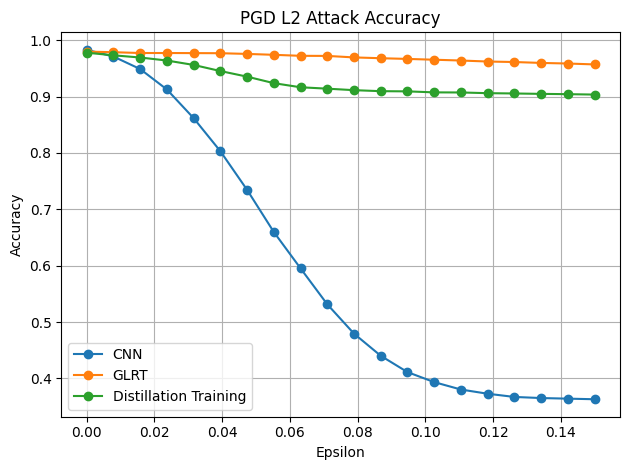

In [23]:
pgd_l2.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "distill_trained"],
    marker='o'
)

plt.title("PGD L2 Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "Distillation Training"])
plt.tight_layout()
plt.show()

In [29]:
pgd_l2.to_csv('../results/baseline/pgd_l2_accuracy_with_distill.csv', index=False)